In [1]:
from tqdm import tqdm
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import scipy
import copy
import sys
import os
from typing import Optional, Union, Sequence, Mapping, List, Set
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from matplotlib.lines import Line2D
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

sys.path.append('/mnt/c/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/QiskitProjects/VariationalWavefunction/')

from quantum_kernel.code.utils import get_dataset
from quantum_kernel.code.visualization_utils import aggregate_shapes,filter_df
from quantum_kernel.code.kernel_measures.kernel_geometry import purity_average, purity_of_average
from quantum_kernel.code.kernel_measures.eigenvalue_scaling import get_eigenvalue_scaling

font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 18}

rc('font', **font)

tqdm.pandas()
warnings.filterwarnings("ignore")


In [2]:
# Get kernel results for the different ml models and dataset.d
dfs = {}
folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQP/gennorm",'Sparse_IQP'),
]

for folder,prefix in folders:
    if prefix in dfs:
        temp = aggregate_shapes(folder,prefix)
        dfs[prefix] = pd.concat([dfs[prefix], temp])
    else:
        dfs[prefix] = aggregate_shapes(folder,prefix)


In [3]:
save_folder='/mnt/c/Users/lslat/Data/QK_project/results/figs/'

In [4]:
iqp_df=dfs['Sparse_IQP']

In [5]:
def compute_dataframe_kernel_eigenvalues(df: pd.DataFrame,filter: dict = {}, k: int = 1):
    """
    compute the kth largest kernel eigenvalues for a dataframe after filter. return filtered dataframe with new column 'kernel_eigenvalues'.
    """
    filtered_df=filter_df(df,filter)
    #-1* matrix so we get the 'kth lowest eigenvalues' then take absolute value to make positive.
    filtered_df['kernel_eigenvalues']=filtered_df.apply(lambda row: np.abs(scipy.linalg.eigh(-1*row.qkern_matrix_train,eigvals_only=True,subset_by_index=(0,k-1)))/row.qkern_matrix_train.shape[0], axis=1)
    return filtered_df

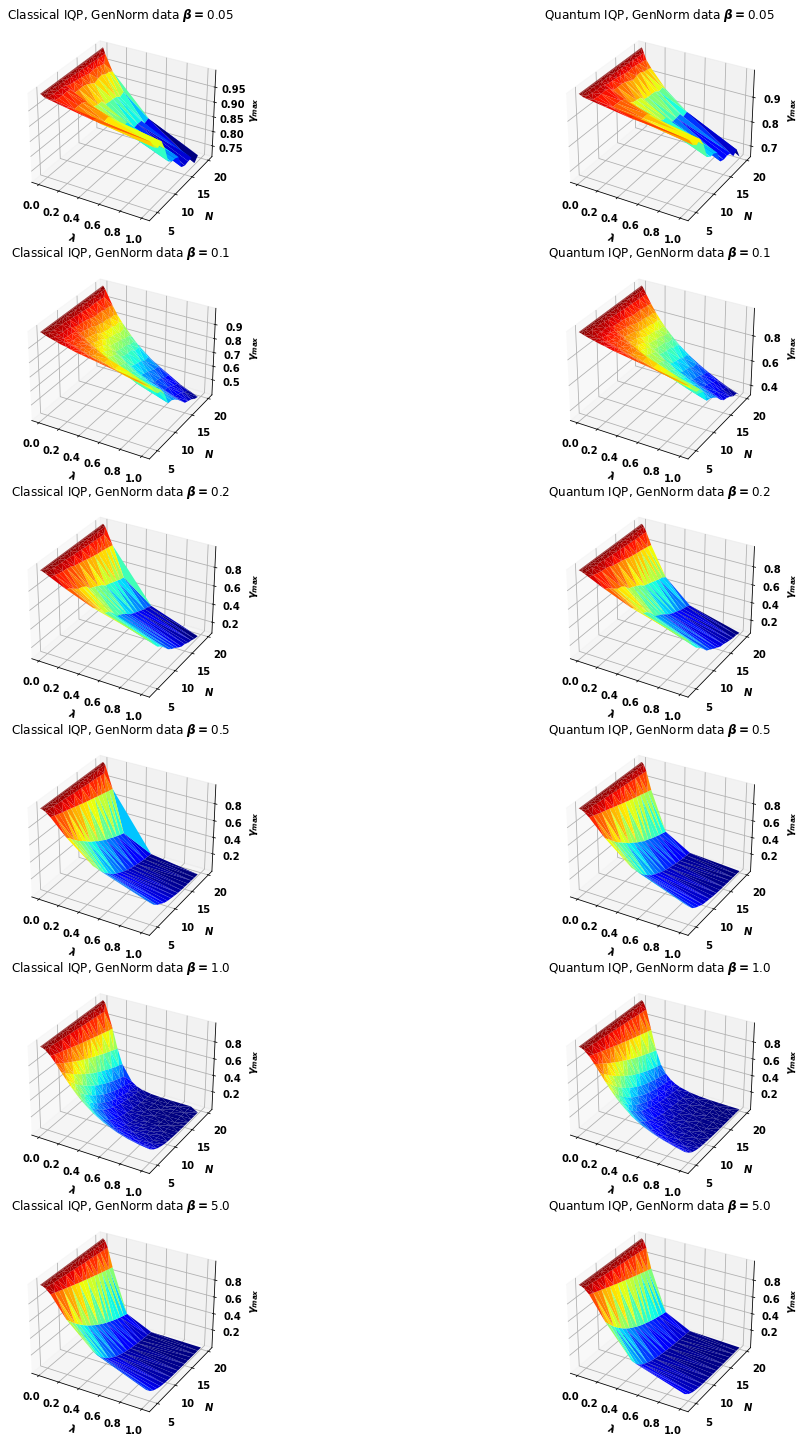

In [6]:
betas=[0.05, 0.1, 0.2, 0.5, 1.0, 5.0]
fig, axs = plt.subplots(len(betas),2,subplot_kw={"projection": "3d"},figsize=(20,20))
for i,beta in enumerate(betas):
    filter={'beta': beta}
    new_df=compute_dataframe_kernel_eigenvalues(iqp_df,filter,k=3)

    classical_df=new_df[(new_df['density']==0)]
    cl_x=classical_df.scaling_factor
    cl_y=classical_df.dataset_dim
    cl_z=classical_df.apply(lambda x: max(x.kernel_eigenvalues),axis=1)

    q_df=new_df[(new_df['density']!=0)]
    q_x=q_df.scaling_factor
    q_y=q_df.dataset_dim
    q_z=q_df.apply(lambda x: max(x.kernel_eigenvalues),axis=1)

    
    ax=axs[i][0]
    ax.plot_trisurf(cl_x,cl_y,cl_z,cmap=cm.jet)
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('$N$')
    ax.set_zlabel('$\gamma_{max}$')
    ax.set_title(rf'Classical IQP, GenNorm data $\beta=${beta}')

    ax=axs[i][1]
    ax.plot_trisurf(q_x,q_y,q_z,cmap=cm.jet)
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('$N$')
    ax.set_zlabel('$\gamma_{max}$')
    ax.set_title(rf'Quantum IQP, GenNorm data $\beta=${beta}')
    
fig.tight_layout()
#fig.savefig(f'{save_folder}IQP_gennorm_data_surface_plots.pdf')

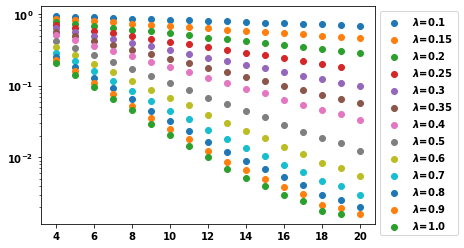

In [7]:
beta=1.0
filter={'beta': beta}
new_df=compute_dataframe_kernel_eigenvalues(iqp_df,filter,k=3)

#sfs=[0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1.0]
#sfs=[0.25,1.0]
sfs=[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for sf in sfs:
    classical_df=new_df[(new_df['density']==0) & (new_df['scaling_factor']==sf)]
    x=classical_df.dataset_dim
    y=classical_df.apply(lambda x: max(x.kernel_eigenvalues),axis=1)
    plt.scatter(x,y,label=r'$\lambda$='+str(sf))
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))

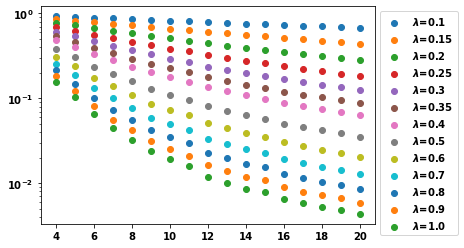

In [8]:
beta=1.0
filter={'beta': beta}
new_df=compute_dataframe_kernel_eigenvalues(iqp_df,filter,k=3)

#sfs=[0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1.0]
#sfs=[0.1, 0.25,1.0]
sfs=[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for sf in sfs:
    q_df=new_df[(new_df['density']!=0) & (new_df['scaling_factor']==sf)]
    x=q_df.dataset_dim
    y=q_df.apply(lambda x: max(x.kernel_eigenvalues),axis=1)
    plt.scatter(x,y,label=r'$\lambda$='+str(sf))
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))

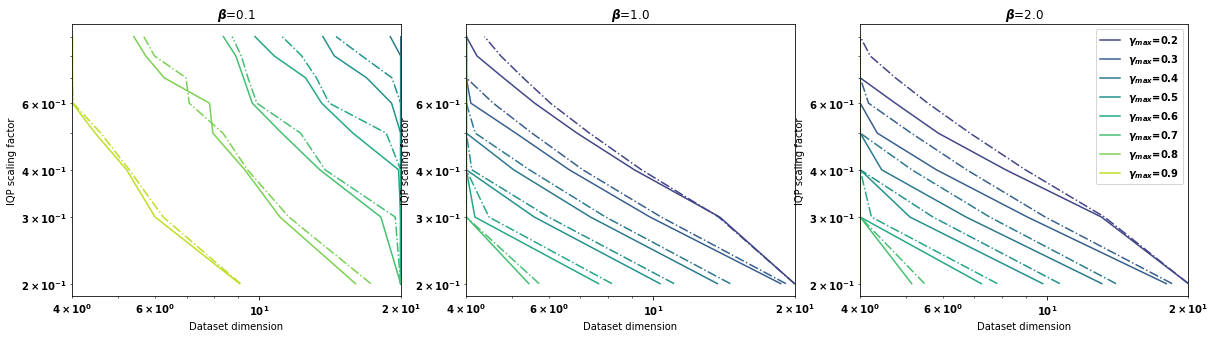

In [9]:
colormap=cm.viridis
gammas=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
test_sfs=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.9]
betas=[0.1,1.0,2.0]
fig, axs = plt.subplots(1,len(betas),figsize=(20,5))
for i,beta in enumerate(betas):
    filter={'beta': beta}
    new_df=compute_dataframe_kernel_eigenvalues(iqp_df,filter,k=3)

    ax=axs[i]
    quantum_df=new_df[(new_df['density']!=0)]
    classical_df=new_df[(new_df['density']==0)]

    lines=[]
    handles=[]
    for gamma in gammas:
        q_curve=get_eigenvalue_scaling(quantum_df,gamma,test_sfs)
        c_curve=get_eigenvalue_scaling(classical_df,gamma,test_sfs)
        label=r'$\gamma_{max}$='+str(gamma)
        color=colormap(gamma)
        line=ax.plot(q_curve[:,0],q_curve[:,1],label=label,color=color)
        _=ax.plot(c_curve[:,0],c_curve[:,1],color=color,ls='-.')
        lines.append(line[0])
        handles.append(label)

    ax.set_xlabel('Dataset dimension')
    ax.set_ylabel('IQP scaling factor')
    ax.set_xlim([4,20])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(r'$\beta$='+str(beta))

ax.legend(lines,handles,bbox_to_anchor=(1,1))
#fig.savefig(f'{save_folder}IQP_fixed_gamma_decay_curves_plots.pdf')

In [10]:
beta=1.0
gamma=0.2

filter={'beta': beta}
new_df=compute_dataframe_kernel_eigenvalues(iqp_df,filter,k=3)
quantum_df=new_df[(new_df['density']!=0)]

q_curve=get_eigenvalue_scaling(quantum_df,gamma,test_sfs)

In [11]:
dataset_dims=[5,6,7,8,9,10,11,12,13,14,15,16,17,18]
target_lams=[np.interp(x,q_curve[:,0][::-1],q_curve[:,1][::-1]) for x in dataset_dims]

In [12]:
target_lams

[0.6745147380670223,
 0.5684518372842262,
 0.49476028790019533,
 0.44998769698234725,
 0.4052151060644992,
 0.3813693660751997,
 0.36028254130998344,
 0.3391957165447671,
 0.3181088917795508,
 0.29770041798863284,
 0.2814170149905274,
 0.2651336119924219,
 0.24885020899431642,
 0.23256680599621096]

In [13]:
import numpy as np
import pandas as pd

def get_eigenvalue_scaling(df: pd.DataFrame,gamma,lambdas):
    """
    Take data frame with max eigenvalue of kernel column,lambda column and dataset dim column.
    Create interpolation between max eigenvalue vs. N for each value of lambda. Find N returning gamma using 
    the interpolation. return List[(N,lambda)] for gamma.
    """
    assert((gamma > 0) & (gamma <= 1.0)),'gamma must be between 0 and 1.'
    points=[]
    for lam in lambdas:
        lam_df=df[(df['scaling_factor']==lam)]
        #note xp and yp are different than lambda vs. N normally plotted because we want to interpolate to find the x intercept.
        yp=lam_df.dataset_dim
        xp=lam_df.apply(lambda x: max(x.kernel_eigenvalues),axis=1)
        #sort for interpolation
        xp,yp=zip(*sorted(zip(xp.values, yp.values), key=lambda x: x[0]))

        n=np.interp(gamma,xp,yp)
        
        points.append((n,lam))
    return np.array(points)

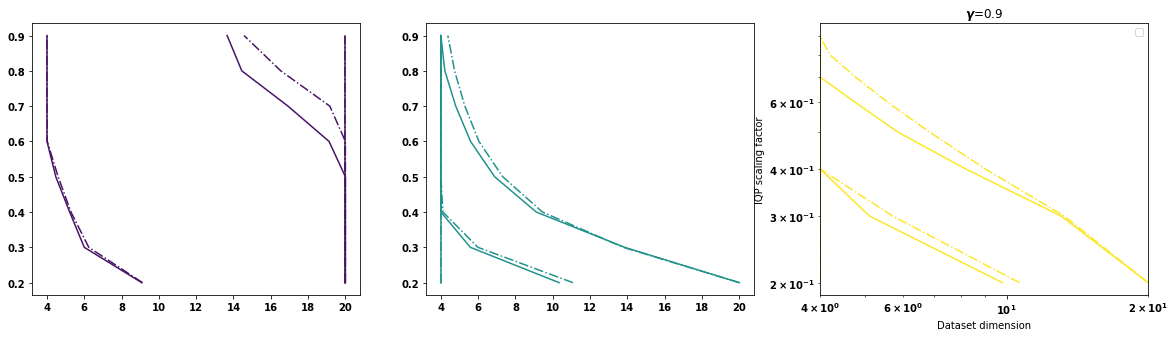

In [14]:
colormap=cm.viridis
gammas=[0.2,0.5,0.9]
test_sfs=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
betas=[0.1,1.0,2.0]
fig, axs = plt.subplots(1,len(gammas),figsize=(20,5))
for gamma in gammas:
    lines=[]
    handles=[]
    for i,beta in enumerate(betas):
        filter={'beta': beta}
        new_df=compute_dataframe_kernel_eigenvalues(iqp_df,filter,k=3)

        ax=axs[i]
        quantum_df=new_df[(new_df['density']!=0)]
        classical_df=new_df[(new_df['density']==0)]

        
    
        q_curve=get_eigenvalue_scaling(quantum_df,gamma,test_sfs)
        c_curve=get_eigenvalue_scaling(classical_df,gamma,test_sfs)
        #label=r'$\gamma_{max}$='+str(gamma)
        #color=colormap(gamma)
        label=r'$\beta$='+str(beta)
        color=colormap(beta/max(betas))
        line=ax.plot(q_curve[:,0],q_curve[:,1],label=label,color=color)
        _=ax.plot(c_curve[:,0],c_curve[:,1],color=color,ls='-.')

        lines.append(line)
        handles.append(label)

    ax.set_xlabel('Dataset dimension')
    ax.set_ylabel('IQP scaling factor')
    ax.set_xlim([4,20])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(r'$\gamma$='+str(gamma))

ax.legend(lines,handles,bbox_to_anchor=(1,1))
fig.savefig(f'{save_folder}IQP_fixed_gamma_decay_curves_plots2.pdf')